In [1]:
import os
import torch.nn as nn
import argparse
import deepcore.nets as nets
import deepcore.datasets as datasets
import deepcore.methods as methods
from torchvision import transforms
from utils import *
from datetime import datetime
from time import sleep

# custom
from ptflops import get_model_complexity_info

# ImageNet30 with 224x224 & ResNet18

In [3]:
import easydict
 
args = easydict.EasyDict({
        # Setup
        "dataset": 'ImageNet30',
        "core_resolution": 224,
        "resolution": 224,
        "core_model": 'ResNet18',
        "model":"ResNet18",
        "fraction": 0.05,
        "num_exp":1,
        "seed": 0,
        "data_path":'../data',
        "gpu":[1],
        "workers": 10,
        "print_freq":300,
        # Optimization
        "epochs":200,
        "batch_size": 128,
        "optimizer": 'SGD',
        "lr":0.1,
        "min_lr": 1e-4,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "nesterov": True,
        "scheduler": "CosineAnnealingLR",
        "selection_optimizer": "SGD",
        "selection_batch": 128,
        "selection_momentum": 0.9,
        "selection_weight_decay": 5e-4,
        "selection_nesterov": True,
        "selection_lr": 0.1,
        "selection_test_interval": 1,
        "selection_test_fraction": 1,
        # Coreset
        "selection": "Uncertainty", #kCenterGreedy Uncertainty
        "selection_epochs": 1,
        "balance": True,
        "uncertainty": 'Margin',
        "submodular": "GraphCut",
        "submodular_greedy": "LazyGreedy",
        "resume": 10
})
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets.__dict__[args.dataset](args)
args.channel, args.im_size, args.num_classes, args.class_names = channel, im_size, num_classes, class_names
torch.random.manual_seed(args.seed) #
print("im_size for coreset: ", dst_train[0][0].shape)

im_size for coreset:  torch.Size([3, 224, 224])


In [5]:
selection_args = dict(epochs=args.selection_epochs,
                        selection_method=args.uncertainty,
                        balance=args.balance,
                        greedy=args.submodular_greedy,
                        function=args.submodular,
                        dst_test = dst_test
                        )
method = methods.__dict__[args.selection](dst_train, args, args.fraction, args.seed, **selection_args)
start_time = time.time()
##### Main Function #####
subset, warmup_test_acc = method.select()

core_selection_time = time.time() - start_time
print("Elapsed Time: ", core_selection_time)

Warm-up Model: ResNet18
MACs:                           1.82 GMac
Number of parameters:           11.19 M 


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


=> Training Epoch #0
| Epoch [  0/  1] Iter[  1/305]		Loss: 3.4326
| Epoch [  0/  1] Iter[301/305]		Loss: 2.3105
=> Warm-up Testing Epoch #0
 Test Acc: 32.267%
Warmup Training Time:  30.921378135681152
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11]
| Selecting for batch [  1/ 11

In [22]:
# To get cnn embeddings
model = method.model
modules=list(model.children())[:-2]
model=nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False

In [13]:
list(method.model.module.children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [9]:
# Selected subset
dst_subset = torch.utils.data.Subset(dst_train, subset["indices"])

# Selected Dataloader
train_loader = DataLoaderX(dst_subset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=False)

In [23]:
outputs = None
targets = None
for i, (input, label) in enumerate(train_loader):
    input = input.to(args.device)
    label = label.to(args.device).cpu()

    embs = model(input)#.reshape((-1,512))#.detach()#.cpu()
    print(embs.shape)
    break

    if outputs == None:
        outputs = embs
        targets = label
    else:
        outputs = torch.cat([outputs, embs], dim=0)
        targets = torch.cat([targets, label], dim=0)
print(outputs.shape)
print(targets.shape)

torch.Size([128, 3, 224, 224])


AttributeError: 'NoneType' object has no attribute 'shape'

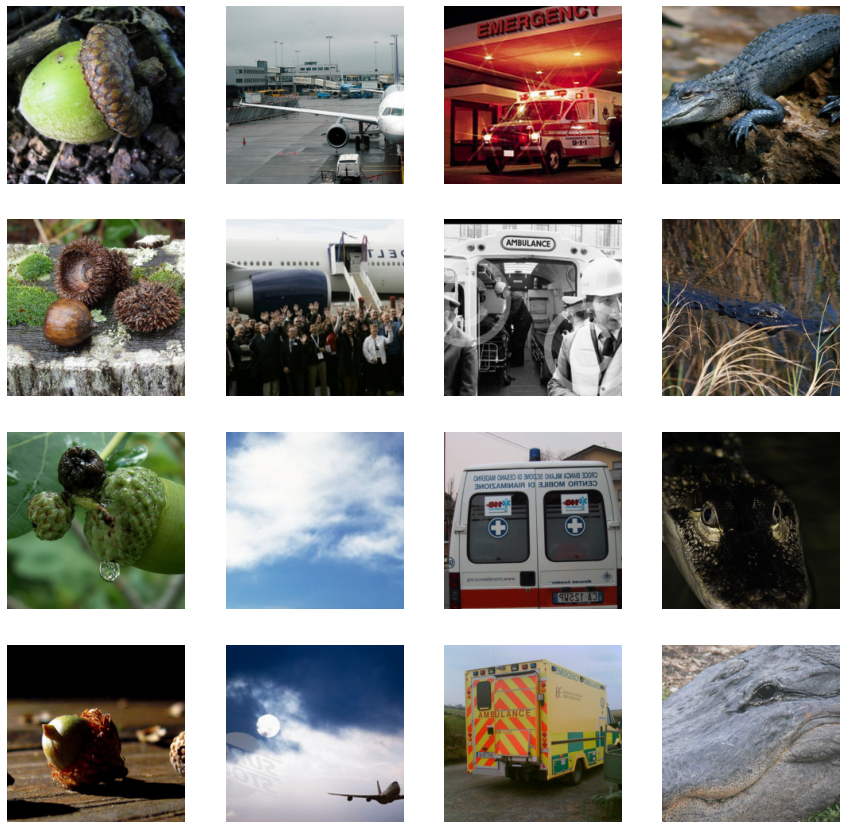

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  

fig = plt.figure(figsize=(15, 15))
rows = 4
cols = 4
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        if i == 0:
            img = to_pil_image(unorm(dst_subset[j*65+0][0]))
        if i == 1:
            img = to_pil_image(unorm(dst_subset[j*65+1][0]))
        if i == 2:
            img = to_pil_image(unorm(dst_subset[j*65+2][0]))
        if i == 3:
            img = to_pil_image(unorm(dst_subset[j*65+3][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

In [13]:
# Non-Selected subset
non_selected_subset = list(set(list(range(len(dst_train))))-set(subset["indices"]))
print(len(non_selected_subset))
dst_subset2 = torch.utils.data.Subset(dst_train, non_selected_subset)

# Non-Selected Dataloader
train_loader2 = DataLoaderX(dst_subset2, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=False)

37050


In [18]:
outputs_non = None
targets_non = None
for i, (input, label) in enumerate(train_loader2):
    input = input.to(args.device)
    label = label.to(args.device).cpu()

    embs = model(input).detach().cpu().reshape((-1,512))

    if outputs_non == None:
        outputs_non = embs
        targets_non = label
    else:
        outputs_non = torch.cat([outputs_non, embs], dim=0)
        targets_non = torch.cat([targets_non, label], dim=0)
print(outputs_non.shape)
print(targets_non.shape)

torch.Size([10892700, 512])
torch.Size([37050])


In [135]:
x = torch.cat([outputs, outputs_non], dim=0)
y = torch.cat([targets, targets_non], dim=0)

## TSNE, ImageNet30, 224x224, First 5 classes, kCenterGreedy, ResNet18

In [136]:
from sklearn.manifold import TSNE

tsne_x = TSNE(n_components = 2).fit_transform(x)

(65, 2)
(1235, 2)


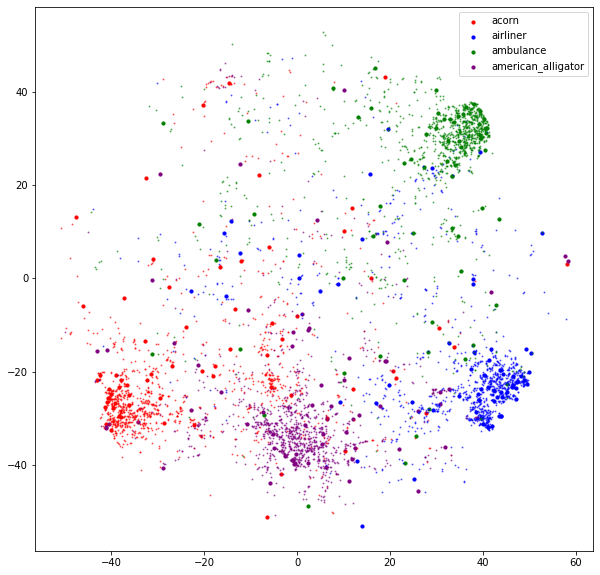

In [138]:
import matplotlib.pyplot as plt

x_core, y_core = tsne_x[:len(targets)], y[:len(targets)]
x_non, y_non = tsne_x[len(targets):], y[len(targets):]

# group by target
x_core_0 = x_core[y_core==0]
x_core_1 = x_core[y_core==1]
x_core_2 = x_core[y_core==2]
x_core_3 = x_core[y_core==3]
x_core_4 = x_core[y_core==4]
print(x_core_0.shape)

x_non_0 = x_non[y_non==0]
x_non_1 = x_non[y_non==1]
x_non_2 = x_non[y_non==2]
x_non_3 = x_non[y_non==3]
x_non_4 = x_non[y_non==4]
print(x_non_0.shape)

plt.figure(figsize=(10, 10))
# target 별 시각화
plt.scatter(x_core_0[:,0], x_core_0[:,1], s=10, color = 'red', label = 'acorn')
plt.scatter(x_core_1[:,0], x_core_1[:,1], s=10, color = 'blue', label = 'airliner')
plt.scatter(x_core_2[:,0], x_core_2[:,1], s=10, color = 'green', label = 'ambulance')
plt.scatter(x_core_3[:,0], x_core_3[:,1], s=10, color = 'purple', label = 'american_alligator')
#plt.scatter(x_core_4[:,0], x_core_4[:,1], s=10, color = 'skyblue', label = 'banjo')

plt.scatter(x_non_0[:,0], x_non_0[:,1], s=1, alpha=0.5, color = 'red')
plt.scatter(x_non_1[:,0], x_non_1[:,1], s=1, alpha=0.5, color = 'blue')
plt.scatter(x_non_2[:,0], x_non_2[:,1], s=1, alpha=0.5, color = 'green')
plt.scatter(x_non_3[:,0], x_non_3[:,1], s=1, alpha=0.5, color = 'purple')
#plt.scatter(x_non_4[:,0], x_non_4[:,1], s=1, alpha=0.5, color = 'skyblue')

#plt.xlabel('component 0')
#plt.ylabel('component 1')
plt.legend(loc='best')
plt.show()

# ImageNet30 with 32x32 & LeNet

In [ ]:
import easydict
 
args = easydict.EasyDict({
        # Setup
        "dataset": 'ImageNet30',
        "core_resolution": 32,
        "resolution": 224,
        "core_model": 'LeNet',
        "model":"ResNet18",
        "fraction": 0.05,
        "num_exp":1,
        "seed": 0,
        "data_path":'../data',
        "gpu":[1],
        "workers": 10,
        "print_freq":300,
        # Optimization
        "epochs":200,
        "batch_size": 128,
        "optimizer": 'SGD',
        "lr":0.1,
        "min_lr": 1e-4,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "nesterov": True,
        "scheduler": "CosineAnnealingLR",
        "selection_optimizer": "SGD",
        "selection_batch": 128,
        "selection_momentum": 0.9,
        "selection_weight_decay": 5e-4,
        "selection_nesterov": True,
        "selection_lr": 0.1,
        "selection_test_interval": 1,
        "selection_test_fraction": 1,
        # Coreset
        "selection": "kCenterGreedy", #kCenterGreedy Uncertainty
        "selection_epochs": 10,
        "balance": True,
        "uncertainty": 'Margin',
        "submodular": "GraphCut",
        "submodular_greedy": "LazyGreedy",
        "resume": 10
})
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
args.resolution = args.core_resolution
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets.__dict__[args.dataset](args)
args.channel, args.im_size, args.num_classes, args.class_names = channel, im_size, num_classes, class_names
torch.random.manual_seed(args.seed) #
print("im_size for coreset: ", dst_train[0][0].shape)

In [ ]:
selection_args = dict(epochs=args.selection_epochs,
                        selection_method=args.uncertainty,
                        balance=args.balance,
                        greedy=args.submodular_greedy,
                        function=args.submodular,
                        dst_test = dst_test
                        )
method = methods.__dict__[args.selection](dst_train, args, args.fraction, args.seed, **selection_args)
start_time = time.time()
##### Main Function #####
subset, warmup_test_acc = method.select()

core_selection_time = time.time() - start_time
print("Elapsed Time: ", core_selection_time)

In [ ]:
# To get cnn embeddings
model = method.model
modules=list(model.modules())[1]
model=nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
model

In [ ]:
# Selected subset
dst_subset = torch.utils.data.Subset(dst_train, subset["indices"])

# Selected Dataloader
train_loader = DataLoaderX(dst_subset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=False)

In [ ]:
outputs = None
targets = None
for i, (input, label) in enumerate(train_loader):
    input = input.to(args.device)
    label = label.to(args.device).cpu()

    embs = model(input).reshape((-1,400)).detach().cpu()

    if outputs == None:
        outputs = embs
        targets = label
    else:
        outputs = torch.cat([outputs, embs], dim=0)
        targets = torch.cat([targets, label], dim=0)
print(outputs.shape)
print(targets.shape)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  

args.resolution = 224
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets.__dict__[args.dataset](args)
args.channel, args.im_size, args.num_classes, args.class_names = channel, im_size, num_classes, class_names
torch.random.manual_seed(args.seed) #
print("im_size for coreset: ", dst_train[0][0].shape)

# Selected subset
dst_subset = torch.utils.data.Subset(dst_train, subset["indices"])

# Selected Dataloader
train_loader = DataLoaderX(dst_subset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=False)

fig = plt.figure(figsize=(15, 15))
rows = 4
cols = 4
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        if i == 0:
            img = to_pil_image(unorm(dst_subset[j*65+0][0]))
        if i == 1:
            img = to_pil_image(unorm(dst_subset[j*65+1][0]))
        if i == 2:
            img = to_pil_image(unorm(dst_subset[j*65+2][0]))
        if i == 3:
            img = to_pil_image(unorm(dst_subset[j*65+3][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

In [ ]:
# Non-Selected subset
non_selected_subset = list(set(list(range(len(dst_train))))-set(subset["indices"]))
print(len(non_selected_subset))
dst_subset2 = torch.utils.data.Subset(dst_train, non_selected_subset)

# Non-Selected Dataloader
train_loader2 = DataLoaderX(dst_subset2, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=False)

In [ ]:
outputs_non = None
targets_non = None
for i, (input, label) in enumerate(train_loader2):
    input = input.to(args.device)
    label = label.to(args.device).cpu()

    embs = model(input).reshape((-1,400)).detach().cpu()

    if outputs_non == None:
        outputs_non = embs
        targets_non = label
    else:
        outputs_non = torch.cat([outputs_non, embs], dim=0)
        targets_non = torch.cat([targets_non, label], dim=0)
print(outputs_non.shape)
print(targets_non.shape)

In [ ]:
x = torch.cat([outputs, outputs_non], dim=0)
y = torch.cat([targets, targets_non], dim=0)

In [ ]:
from sklearn.manifold import TSNE

tsne_x = TSNE(n_components = 2).fit_transform(x)

In [ ]:
import matplotlib.pyplot as plt

x_core, y_core = tsne_x[:len(targets)], y[:len(targets)]
x_non, y_non = tsne_x[len(targets):], y[len(targets):]

# group by target
x_core_0 = x_core[y_core==0]
x_core_1 = x_core[y_core==1]
x_core_2 = x_core[y_core==2]
x_core_3 = x_core[y_core==3]
x_core_4 = x_core[y_core==4]
print(x_core_0.shape)

x_non_0 = x_non[y_non==0]
x_non_1 = x_non[y_non==1]
x_non_2 = x_non[y_non==2]
x_non_3 = x_non[y_non==3]
x_non_4 = x_non[y_non==4]
print(x_non_0.shape)

plt.figure(figsize=(10, 10))
# target 별 시각화
plt.scatter(x_core_0[:,0], x_core_0[:,1], s=10, color = 'red', label = 'acorn')
plt.scatter(x_core_1[:,0], x_core_1[:,1], s=10, color = 'blue', label = 'airliner')
plt.scatter(x_core_2[:,0], x_core_2[:,1], s=10, color = 'green', label = 'ambulance')
plt.scatter(x_core_3[:,0], x_core_3[:,1], s=10, color = 'purple', label = 'american_alligator')
#plt.scatter(x_core_4[:,0], x_core_4[:,1], s=10, color = 'skyblue', label = 'banjo')

plt.scatter(x_non_0[:,0], x_non_0[:,1], s=1, alpha=0.5, color = 'red')
plt.scatter(x_non_1[:,0], x_non_1[:,1], s=1, alpha=0.5, color = 'blue')
plt.scatter(x_non_2[:,0], x_non_2[:,1], s=1, alpha=0.5, color = 'green')
plt.scatter(x_non_3[:,0], x_non_3[:,1], s=1, alpha=0.5, color = 'purple')
#plt.scatter(x_non_4[:,0], x_non_4[:,1], s=1, alpha=0.5, color = 'skyblue')

#plt.xlabel('component 0')
#plt.ylabel('component 1')
plt.legend(loc='best')
plt.show()